In [37]:
import numpy as np
from scipy.io import loadmat
from torch import nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
import torch.utils.data as Data
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
salinas_label = loadmat('../data2/Salinas_gt.mat')['salinas_gt']
salinas_data = loadmat('../data2/Salinas_corrected.mat')['salinas_corrected']

In [3]:
label_dic = {}
for i in range(salinas_label.shape[0]):
    for j in range(salinas_label.shape[1]):
        if salinas_label[i][j] in label_dic:
            label_dic[salinas_label[i][j]] += 1
        else:
            label_dic[salinas_label[i][j]] = 1
print(label_dic)

{0: 56975, 6: 3959, 7: 3579, 4: 1394, 5: 2678, 15: 7268, 8: 11271, 3: 1976, 2: 3726, 1: 2009, 11: 1068, 12: 1927, 13: 916, 14: 1070, 10: 3278, 9: 6203, 16: 1807}


In [4]:
def get_binary_data(data, label, selected_labels):
    res_data = []
    res_label = []
    for i in range(label.shape[0]):
        for j in range(label.shape[1]):
            if label[i][j] in selected_labels:
                res_data.append(data[i, j, :])
                res_label.append(selected_labels[label[i][j]])
    return np.array(res_data), np.array(res_label)

In [5]:
t_data, t_label = get_binary_data(salinas_data, salinas_label, {8:0, 16:1})

In [6]:
data_1 = []
label_1 = []
data_0 = []
label_0 = []
for i in range(len(t_label)):
    if t_label[i] == 1:
        data_1.append(t_data[i])
        label_1.append(t_label[i])
    else:
        data_0.append(t_data[i])
        label_0.append(t_label[i])
print(len(data_0), len(data_1))

11271 1807


In [19]:
train_x = data_0[:10000]
train_y = label_0[:10000]
test_x = data_0[10000:] + data_1
test_y = label_0[10000:] + label_1
train_x, test_x, train_y, test_y = np.array(train_x, dtype=np.float64), np.array(test_x, dtype=np.float64), np.array(train_y, np.float64), np.array(test_y, dtype=np.float64)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(10000, 204) (3078, 204) (10000,) (3078,)


In [20]:
train_scaler = StandardScaler()
train_scaler.fit(train_x)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [22]:
train_x = train_scaler.transform(train_x)
test_x = train_scaler.transform(test_x)

In [26]:
class Generator(torch.nn.Module):
    def __init__(self, n_feature, n_output):
        super(Generator, self).__init__()
        self.hidden_size_1 = 64
        self.hidden_size_2 = 64

        self.hidden_1 = nn.Linear(n_feature, self.hidden_size_1)
        self.hidden_2 = nn.Linear(self.hidden_size_1, self.hidden_size_2)
        self.output = nn.Linear(self.hidden_size_2, n_output)

    def forward(self, x):
        x = F.relu(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        x = self.output(x)
        return x


class Discriminator(torch.nn.Module):
    def __init__(self, n_feature, n_output):
        super(Discriminator, self).__init__()
        self.hidden_size_1 = 64
        self.hidden_size_2 = 64

        self.hidden_1 = nn.Linear(n_feature, self.hidden_size_1)
        self.hidden_2 = nn.Linear(self.hidden_size_1, self.hidden_size_2)
        self.output = nn.Linear(self.hidden_size_2, n_output)

    def forward(self, x):
        x = F.relu(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        x = F.sigmoid(self.output(x))
        return x

In [27]:
def prepare_batch_data(train_x, test_x, train_y, test_y, use_cuda=False, add_axis=False):
    if add_axis:
        train_x = train_x[:, np.newaxis, :]
        test_x = test_x[:, np.newaxis, :]
    if use_cuda:
        train_x = torch.FloatTensor(train_x).cuda()
        test_x = Variable(torch.FloatTensor(test_x)).cuda()
        train_y = torch.LongTensor(np.squeeze(np.asarray(train_y, dtype=np.int64))).cuda()
        test_y = Variable(torch.LongTensor(np.squeeze(np.asarray(test_y, dtype=np.int64))))
    else:
        train_x = torch.FloatTensor(train_x)
        test_x = Variable(torch.FloatTensor(test_x))
        train_y = torch.LongTensor(np.squeeze(np.asarray(train_y, dtype=np.int64)))
        test_y = Variable(torch.LongTensor(np.squeeze(np.asarray(test_y, dtype=np.int64))))
    return train_x, test_x, train_y, test_y

train_x, test_x, train_y, test_y = prepare_batch_data(train_x, test_x, train_y, test_y)

In [60]:
G = Generator(32, 204)
D = Discriminator(204, 1)

In [61]:
opt_G = torch.optim.Adam(G.parameters(), lr=0.000001)
opt_D = torch.optim.Adam(D.parameters(), lr=0.000001)
train_dataset = Data.TensorDataset(train_x, train_y)
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True
)

In [ ]:
G.train()
D.train()
prob_0s = []
prob_1s = []
G_losses = []
D_losses = []
for epoch in range(10000):
    if epoch % 10 == 0:
        print(epoch, 'training...')
    for step, (batch_x, batch_y) in enumerate(train_loader):
        batch_x, batch_y = Variable(batch_x), Variable(batch_y)
        G_ideas = Variable(torch.randn(16, 32), requires_grad=True)
        G_output = G(G_ideas)

        prob_0 = D(batch_x)
        prod_1 = D(G_output)
        
        prob_0s.append(prob_0)
        prob_1s.append(prod_1)

        D_loss = - torch.mean((torch.log(prob_0)) + (torch.log(1. - prod_1)))
        G_loss = torch.mean(torch.log(1. - prod_1))
        
        G_losses.append(G_loss)
        D_losses.append(D_loss)

        opt_D.zero_grad()
        D_loss.backward(retain_variables=True) # (retain_variables=True
        opt_D.step()

        opt_G.zero_grad()
        G_loss.backward()
        opt_G.step()

0 training...
10 training...
20 training...
30 training...
40 training...
50 training...
60 training...
70 training...
80 training...
90 training...
100 training...
110 training...
120 training...
130 training...
140 training...
150 training...
160 training...
170 training...
180 training...
190 training...
200 training...
210 training...
220 training...
230 training...
240 training...
250 training...
260 training...
270 training...
280 training...
290 training...
300 training...
310 training...
320 training...
330 training...
340 training...
350 training...
360 training...
370 training...
380 training...
390 training...
400 training...
410 training...
420 training...
430 training...
440 training...
450 training...
460 training...
470 training...
480 training...
490 training...
500 training...
510 training...
520 training...
530 training...
540 training...
550 training...
560 training...
570 training...
580 training...


In [41]:
D.eval()
test_pre = D(test_x)

In [42]:
test_pre = test_pre.data.numpy()

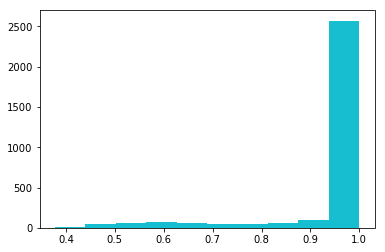

In [45]:
plt.hist(test_pre)
plt.show()

In [46]:
test_0 = test_pre[:1271]
test_1 = test_pre[1271:]

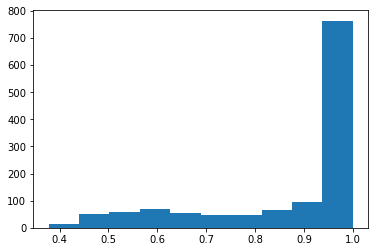

In [47]:
plt.hist(test_0)
plt.show()

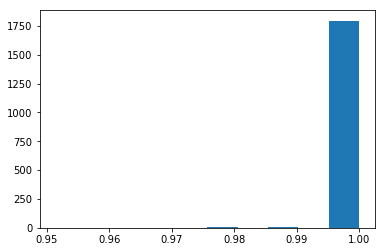

In [48]:
plt.hist(test_1)
plt.show()

In [57]:
count = 0
for i in test_0:
    if i > 0.99:
        count += 1
print(count)

582


In [58]:
count = 0
for i in test_1:
    if i < 0.97:
        count += 1
print(count)

4


In [59]:
586 / 3078

0.1903833658219623